## Creating dataframes from wikipedia biographies  
1. Collect names from various Wikipedia lists and store them as CSV files using IMPORTHTML from Google Spreadsheets (not shown)
2. Import csv files as lists or dictionaries as required.
3. Create preliminary dictionary which contains, at a minimum, the following keys: name, gender identity. From many lists we were also able to parse birthday and occupation. For the list of transgender individuals, the gender identity remains unknown (None) because it was not listed in a chart (as in the non-binary list). 
4. Get the text of all wikipedia pages, add it to person dictionaries. Store this list of dictionaries as a json file.
5. For every page's text, find the frequency of a set of words considered to be gender features (a list of pronouns and other gender identifying words)
6. Replace the text key with a feature frequency key and character count key. Store this new list of dictionaries in a json file.
7. Find total features, their frequencies, and proportions for the entire list of people.
8. Group the list of feature words by gender category (i.e. 'she' is grouped into 'woman features'). Find the proportion of woman, man, non-binary, cisgender, and transgender features for each person in the list. Store this new dictionary in a json file.
9. Find the average proportions of gender feature groups for the entire list of people.
10. Visualize results.

In [77]:
from textblob import TextBlob
import nltk
#nltk.download('punkt')
#nltk.download('brown')
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud 
#nltk.download('stopwords')
from bs4 import BeautifulSoup as BS

from mwclient import Site
import requests

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import json
from mwclient import Site
import csv
import re
import plotly.express as px
import plotly.graph_objects as go
import scipy
import statsmodels.formula.api as smf
import matplotlib.colors
from sklearn.linear_model import LinearRegression

Import lists of people from csv files, format as necessary.
1. Male Martial Artists - 314 people from this extensive list.
2. Male Jazz Singers
3. Women Rock Singers
4. Non-binary people
5. Transgender people

In [2]:
def getName(personString):
    '''Takes a string from csv file that has name and other information 
    or extra characters and returns only the name.'''
    #split name from birth year and occupation
    try:
        personList = re.split(" -", personString, 1)
        name = personList[0]
    except:
        print(personString)
        name = personString
    try:
        name = re.split("\\[", name, 1)
        name = name[0]
    except:
        pass
    return name

def getName2(personString):
    '''Takes a string from csv file that has name and other information 
    or extra characters and returns only the name.'''
    #split name from birth year and occupation
    try:
        personList = re.split(" \\(", personString, 1)
        name = personList[0]
    except:
        print(personString)
        name = personString
    return name

def getName3(personString):
    plist = personString.split(' ')
    first = plist[0]
    try: 
        last = plist[1]
        if last[0].isupper():
            #print(last)
            name = first + ' ' +last
            #print(name)
            return name
        else:
            return first
    except:
        return first

It's important to note here that I have assumed the male martial artists, jazz singers, women rock singers, and women in parliment are all cisgender without checking every page, so there could well be errors!! 

In [3]:
with open('male-martial-artists.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink0 = inputFile.readline()
    # second line is table header
    #header = inputFile.readline()
    people = csv.reader(inputFile, delimiter=',')
    pList = []
    for p in people:
        pList.extend(p)

pListNames = [getName(p) for p in pList]
print(pListNames[30:35], len(pListNames))
pDctList = []
for p in pListNames:
    miniDct = dict()
    miniDct['Name'] = p
    miniDct['Gender identity'] = 'Man'
    miniDct['isTrans'] = False
    pDctList.append(miniDct)
print(pDctList[:2])

['Olaf Alfonso', 'Royce Alger', 'Amir Aliakbari', 'Sultan Aliev', 'Ben Alloway'] 314
[{'Name': 'David "Tank" Abbott', 'Gender identity': 'Man', 'isTrans': False}, {'Name': 'Shamil Abdurakhimov', 'Gender identity': 'Man', 'isTrans': False}]


In [4]:
with open('male-jazz-singers.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink1 = inputFile.readline()
    # second line is table header
    #header = inputFile.readline()
    people1 = csv.reader(inputFile, delimiter=',')
    pList1 = []
    for p in people1:
        pList1.extend(p)

print(pList1[30:35], len(pList1))
pDctList1 = []
for p in pList1:
    miniDct = dict()
    miniDct['Name'] = p
    miniDct['Gender identity'] = 'Man'
    miniDct['isTrans'] = False
    pDctList1.append(miniDct)
print(pDctList1[:2])

['Matt Dusk', 'Billy Eckstine', 'Roy Eldridge', 'Kurt Elling', 'Don Elliott'] 128
[{'Name': 'Mose Allison', 'Gender identity': 'Man', 'isTrans': False}, {'Name': 'Ernie Andrews', 'Gender identity': 'Man', 'isTrans': False}]


Combining male jazz singers and male martial artists:

In [5]:
manList = pDctList + pDctList1
print(manList[:2], len(manList))

[{'Name': 'David "Tank" Abbott', 'Gender identity': 'Man', 'isTrans': False}, {'Name': 'Shamil Abdurakhimov', 'Gender identity': 'Man', 'isTrans': False}] 442


Women in rock

In [6]:
with open('female-rock-singers.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink2 = inputFile.readline()
    # second line is table header
    #header = inputFile.readline()
    women = csv.reader(inputFile, delimiter=',')
    wList = []
    for p in women:
        wList.extend(p)
       
wListNames = [getName2(singer) for singer in wList]
print(wListNames[:10])
wDctList = []
for woman in wListNames:
    miniDct = dict()
    miniDct['Name'] = woman
    miniDct['Gender identity'] = 'Woman'
    miniDct['isTrans'] = False
    wDctList.append(miniDct)
print(wDctList[:2])

['Lee Aaron', 'Pearl Aday', 'Sharon den Adel', 'Sade Adu', 'Nanase Aikawa', 'Agent M', 'Dot Allison', 'Zayra Alvarez', 'Amber', 'Tori Amos']
[{'Name': 'Lee Aaron', 'Gender identity': 'Woman', 'isTrans': False}, {'Name': 'Pearl Aday', 'Gender identity': 'Woman', 'isTrans': False}]


Women in UK Parliament

In [7]:
with open('female-parliament.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink3 = inputFile.readline()
    # second line is table header
    #header = inputFile.readline()
    women2 = csv.reader(inputFile, delimiter=',')
    wList2 = []
    for p in women2:
        wList2.extend(p)
wDctList2 = []
for woman in wList2:
    miniDct = dict()
    miniDct['Name'] = woman
    miniDct['Gender identity'] = 'Woman'
    miniDct['isTrans'] = False
    wDctList2.append(miniDct)
print(wDctList2[:2])

[{'Name': 'Aileen Campbell', 'Gender identity': 'Woman', 'isTrans': False}, {'Name': 'Aileen McLeod', 'Gender identity': 'Woman', 'isTrans': False}]


Combining lists of woman rock singers and women in UK parliament

In [8]:
womanList =wDctList + wDctList2
print(womanList[:2], len(womanList))

[{'Name': 'Lee Aaron', 'Gender identity': 'Woman', 'isTrans': False}, {'Name': 'Pearl Aday', 'Gender identity': 'Woman', 'isTrans': False}] 691


List of non-binary people on Wikipedia, note that we were able to read in this list as a dictionary with not only name but also birth year, nationality, gender identity, and notable as.

In [9]:
with open('non-binary-people.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink4 = inputFile.readline()
    # second line is table header
    #header = inputFile.readline()
    nonbinary = csv.DictReader(inputFile, delimiter=',')
    nbList = []
    for dct in nonbinary:
        nbList.append(dct)
       
for dct in nbList:
    dct['isTrans'] = True
    dct.pop('Reference', None)

print(nbList[:3])

[{'Name': 'Courtney Act', 'Birth year': '1982', 'Nationality': 'Australian', 'Gender identity': 'Genderqueer', 'Notable as': 'Drag queen, singer, television personality', 'isTrans': True}, {'Name': 'Aja', 'Birth year': '1994', 'Nationality': 'American', 'Gender identity': 'Genderfluid', 'Notable as': 'Drag queen, rapper, television personality', 'isTrans': True}, {'Name': 'Travis Alabanza', 'Birth year': '1996', 'Nationality': 'British', 'Gender identity': 'Gender non-conforming', 'Notable as': 'Performance artist, poet, writer, LGBTQ rights activist', 'isTrans': True}]


List of transgender people on Wikpedia: Note - there are a great number of inconsistencies in how the list entires are formatted, which suggests the list needs editing. This simple problem makes studying the list much more difficult.

In [10]:
with open('transgender-people.csv', 'r', newline='') as inputFile:
    # first line is link
    wikiLink5 = inputFile.readline()
    transgender = csv.reader(inputFile, delimiter=',')
    tList = []
    for line in transgender:
        tList.extend(line)

transList = [getName3(p) for p in tList]

tDctList = []
for p in transList:
    miniDct = dict()
    miniDct['Name'] = p
    miniDct['Gender identity'] = None
    miniDct['isTrans'] = True
    tDctList.append(miniDct)
print(tDctList[:2])

[{'Name': 'Marja-Sisko Aalto', 'Gender identity': None, 'isTrans': True}, {'Name': 'Alexander James', 'Gender identity': None, 'isTrans': True}]


### Now retrieve text from the wikipedia pages.

**Helper Functions:**

In [11]:
# function Eni wrote - reusing from problem 1 assign 3
def getPageFromWiki(pageName):
    """Given a Wikipedia page name, returns a dictionary of key-values 
    parsed in various structures, such as text, sections, links, etc.
    """
    response = requests.get(
        'https://en.wikipedia.org/w/api.php',
         params={
             'action': 'parse',
             'page': pageName,
             'format': 'json',
        }).json()
    return response

# also reusing this function from problem 1 
def getTextFromWikiPage(personName):
    '''Takes as a parameter the name of a person and returns
    the text of their Wikipedia page as a string. If page does not exist,
    returns a string saying the page does not exist'''
    # use helper function getPageFromWiki
    try:
        response = getPageFromWiki(personName)
        html = response['parse']['text']['*']
        text = BS(html, "lxml")
        return text.text
    except:
        #print(personName, "no text here?")
        pass
    
def addTextPageToDct(dct):
    '''Takes a mini person dictionary like the ones in our lists and
    returns a dictionary with an added key which contains the text
    from their wikipedia page'''
    try:
        name = dct['Name']
        dct['text'] = getTextFromWikiPage(name)
        if dct['text'][:8] == 'Redirect':
            dct['text'] = None
    except TypeError:
        #print(TypeError)
        #print(dct)
        dct['text'] = None
    return dct

def addTextAllDct(dctList):
    '''Runs addTextPageToDct on all dictionaries in a list.
    Separates into two lists, one where text was found, another
    where text was not found (likely due to an error in name
    entered into wikipedia i.e. bday still attached, etc.)'''
    textDct = []
    noneList = []
    for dct in dctList:
        addTextPageToDct(dct)
        if dct['text'] == None:
            noneList.append(dct)
        else:
            textDct.append(dct)
    return (textDct, noneList)

In [12]:
menWiki, menNone = addTextAllDct(manList)
womenWiki, womenNone = addTextAllDct(womanList)
nbWiki, nbNone = addTextAllDct(nbList)



In [13]:
transWiki, transNone = addTextAllDct(tDctList)

In [14]:
print('menWiki length: ', len(menWiki))
print('menNone length: ', len(menNone))
print('womenWiki length: ', len(womenWiki))
print('womenNone length: ', len(womenNone))
print('nbWiki length: ', len(nbWiki))
print('nbNone length: ', len(nbNone))
print('transWiki length: ', len(transWiki))
print('transNone length: ', len(transNone))

menWiki length:  414
menNone length:  28
womenWiki length:  640
womenNone length:  51
nbWiki length:  97
nbNone length:  5
transWiki length:  246
transNone length:  106


As you can see, the 'None' list for the transgender individuals is 106 people, which is a significant chunk of 352. It is also a much greater number than all of the other none lists. The reason for this is because the list of transgender people was difficult to parse -- it was not very well formulated. Given this, I am going to hardcode a number of transNone entries to fix the name, add the gender identity (since I am already going to their pages) and then search again for text.

In [15]:
for dct in transNone:
    dct.pop('text', None)
#transNone

In [16]:
transNoneMod =  [{'Name': 'Alexander James Adams', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Suicide of Leelah Alcorn', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Charlie Jane Anders', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Lucy Hicks Anderson', 'Gender identity': 'Woman', 'isTrans': True},
 #no page about Luke, just mentioned on Big Brother wiki page
 {'Name': 'Luke Anderson', 'Gender identity': None, 'isTrans': True},
 {'Name': 'Nikki Araguz Loyd', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Backxwash', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Grace Banu', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Esben Esther Pirelli Benestad', 'Gender identity': None, 'isTrans': True},
 {'Name': 'S. Bear Bergman', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Danielle Bunten Berry', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Michelle Suárez Bértora', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Justin Vivian Bond', 'Gender identity': 'Gender non-conforming', 'isTrans': True},
 {'Name': 'Jennifer Finney Boylan', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Cait Brennan', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Namoli Brennet', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Z Brewer', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Poppy Z. Brite', 'Gender identity':'Man', 'isTrans': True},
 {'Name': 'Willmer "Little Ax" Broadnax', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Suicide of Blake Brockington', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Sarah Brown', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Sara Davis Buechner', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Mauro Cabral', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Meryn Cadell', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Lynda Cash', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Quinn Christopherson', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Michael D. Cohen', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'T Cooper', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Ruby Corado', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Caroline Cossey', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Laverne Cox', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Phillipe Cunningham', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Mike Penner', 'Gender identity': 'Man', 'isTrans': False},
 {'Name': 'Florencia De La V', 'Gender identity':'Woman', 'isTrans': True},
 {'Name': 'Petra De Sutter', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Michelle Dumaresq', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Amazon Eve', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Florian-Ayala Fauna', 'Gender identity':'Androgyne', 'isTrans': True},
 {'Name': 'Sir Ewan Forbes, 11th Baronet', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Alan L. Hart', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Adela Hernández', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Anderson Bigode Herzer', 'Gender identity': 'Man', 'isTrans': True},
 # Rita Hester does not have her own page, on Trans Day of Remembrance
 {'Name': 'Rita Hester', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Death of Tyra Hunter', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Kim Coco Iwamoto', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Sir Lady Java', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Natasha Jiménez', 'Gender identity': 'Intersex Woman', 'isTrans': True},
 {'Name': 'Jeffrey Catherine Jones', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Paris Lees', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Rachel Levine', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Trevor MacDonald (health researcher)', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Mimi Marks', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Shabnam Mausi', 'Gender identity': 'Hijra', 'isTrans': True},
 {'Name': 'Tiq Milan', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Riley Carter Millington', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Joyita Mondal', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Death of Nizah Morris', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Anwen Muston', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Nikkie de Jager', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Rémy Noë', 'Gender identity': 'Gender non-conforming', 'isTrans': True},
 {'Name': 'Bell Nuntita', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Anne Ogborn', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Pepe Julian Onziema', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Daniel M. Lavery', 'Gender identity': 'Queer', 'isTrans': True},
#actually a page about a murder victim of 
#{'Name': 'Nicole Louise Pearce', 'Gender identity': None, 'isTrans': True},
 {'Name': 'Yasmine Petty', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'John Pilley', 'Gender identity': 'Man', 'isTrans': False},
 {'Name': 'Ángela Ponce', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Midge Potts', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Fay Presto', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Monica Roberts', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Allyson Robinson', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Mj Rodriguez', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Diane Marie Rodríguez Zambrano', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Sonique (entertainer)', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Trish Salah', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Bamby Salcedo', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Fulvia Celica Siguas Sandoval', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Harmony Santana', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Hunter Schafer', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Vivek Shraya', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Lucas Silveira', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Dawn Langley Simmons', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Gwendolyn Ann Smith', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Allanah Starr', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Abby Stein', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Michelle Suárez Bértora', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Kalki Subramaniam', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Jennifer Ventimilia', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'The Wachowskis', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Ramon Te Wake', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Brianna Westbrook', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Blaire White', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Stephen Whittle', 'Gender identity': 'Man', 'isTrans': True},
 {'Name': 'Joanne Rushton', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'ContraPoints', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Sophie (musician)', 'Gender identity': 'Woman', 'isTrans': True},
 {'Name': 'Marie-Pierre Pruvot', 'Gender identity': 'Woman', 'isTrans': True}]

In [17]:
transWiki2, transNone2 = addTextAllDct(transNoneMod)

In [18]:
transWiki = transWiki + transWiki2
transNone = transNone2
print('transWiki length: ', len(transWiki))
print('transNone length: ', len(transNone))

transWiki length:  340
transNone length:  3


Let's save all of the text from each group as well in order to make word clouds later. 

In [19]:
def getAllTextList(wikiList):
    '''Takes the text from all of the text keys and puts it into one big string'''
    string = ''
    for p in wikiList:
        string += p['text']
    return string


In [20]:
menText = getAllTextList(menWiki)
womenText = getAllTextList(womenWiki)
nbText = getAllTextList(nbWiki)
transText = getAllTextList(transWiki)

Now we have all the text dictionaries, time to save them in json files.

In [21]:
def dctJSON(dct, filename):
    '''Takes a dictionary and stores it in a JSON file'''
    with open(filename, 'w') as outfile:
        json.dump(dct, outfile)

In [22]:
dctJSON(transWiki, 'trans-wiki-text.json')
dctJSON(menWiki, 'men-wiki-text.json')
dctJSON(womenWiki, 'women-wiki-text.json')
dctJSON(nbWiki, 'nb-wiki-text.json')
allPages = transWiki + menWiki + womenWiki + nbWiki
dctJSON(allPages, 'population-wiki-text.json')

### Now find feature frequencies for all the person dictionaries

First, define features. Features will first be written as a list, then we also make a dictionary where individual words are grouped into gender categories.

In [23]:
with open('pronouns_tabs.txt', 'r') as inputFile:
    neopronouns = inputFile.read()
neopronouns = neopronouns.split()
features = ["woman", "women", "female", "femme",
            "feminine",
             "man", "men", "male", "masculine", "masc", 
            "cis", "cisgender",
            "trans", "transgender","transsexual", 
            "queer", "non-binary", "gender non-conforming", "two-spirit",
           "hijra", "kinnar", "gender neutral"]
features.extend(neopronouns)

featuresDict = {'wf':["she", "her", "hers", "woman", "women", "female", "femme",
            "feminine"],
                'mf':["he", "him", "his", "man", "men", "male", "masculine", "masc"],
                'nbf':["they", "them", "their", "theirs", "xe", "xem", "xyr", "ze", "hir", "hirs",
             "ey", "em", "eir","queer", "non-binary", "gender non-conforming", "two-spirit",
           "hijra", "kinnar", "gender neutral",'they','them','their','theirs','themselves','ze',
 'hir','hir','hirs','hirself','ze','zir','zir','zirs','zirself','xey','xem','xyr',
 'xyrs','xemself','ae','aer','aer','aers','aerself','e','em','eir','eirs','emself','ey',
 'em','eir','eirs','eirself','fae','faer','faer','faers','faerself','fey','fem','feir',
 'feirs','feirself','hu','hum','hus','hus','humself','jee','jem','jeir','jeirs','jemself',
 'kit','kit','kits','kits','kitself','ne','nem','nir','nirs','nemself','peh',
 'pehm',"peh's","peh's",'pehself','per','per','per','pers','perself','sie','hir',
 'hir','hirs','hirself','se','sim','ser','sers','serself','shi','hir','hir','hirs','hirself','si','hyr','hyr','hyrs',
 'hyrself','they','them','their','theirs','themself','thon','thon','thons','thons','thonself','ve','ver',
 'vis','vis','verself','ve','vem','vir','virs','vemself','vi','ver','ver','vers','verself','vi','vim',
 'vir','virs','vimself','vi','vim','vim','vims','vimself','xie','xer','xer','xers','xerself','xe','xem',
 'xyr','xyrs','xemself','xey','xem','xeir','xeirs','xemself','yo','yo','yos','yos','yosself','ze','zem',
 'zes','zirself','ze','mer','zer','zers','zemself','zee','zed','zeta','zetas','zedself','zie',
 'zir','zirs','zirself','zie','zem','zes','zes','zirself','zie','hir','hir','hirs','hirself','zme','zmyr',
 'zmyr','zmyrs','zmyrself'],
                'cisf':["cis", "cisgender"],
                'tf':["trans", "transgender","transsexual"] }

Two functions used to find feature frequencies, add them to the individual people dictionaries, and then get the character count of the text and then delete the text from the dictionary, as it's already stored in a json file and we don't really need it. Then there are two functions which find the feature frequencies and proportions for an entire list of people.

In [24]:
def getFeatures(personDct):
    '''takes a dictionary that has a person's name and the text from 
    their wikipedia page. Returns counter of the features list
    as the frequencies appear on the page'''
    text = personDct['text'] 
    if text == None:
        return dict()
    # create counter of all words in text
    bigBlob = TextBlob(text)
    wordFreq = Counter(bigBlob.word_counts)
    #filter out words that are 'features' and adjust counter for word frequencies
    wordFreqFiltered = {w: wordFreq[w] for w in wordFreq if w in features}
    #print(wordFreqFiltered) 
    
    return wordFreqFiltered

def addFeaturesReplaceText(personDct):
    '''takes a person dictionary with text value, runs getFeatures on the text,
    adds as key, pops text. We don't need to lug around the texts of wiki pages, already 
    stored in json file anyway.'''
    if personDct['text'] == None:
        personDct['Char Count'] = None
        personDct['genderFeatFreq'] = None
        personDct.pop('text', None)
        return personDct
    else:
        personDct['Char Count'] = len(personDct['text'])
        personDct['genderFeatFreq'] = getFeatures(personDct)
        personDct.pop('text', None)
        return personDct

def allFeaturesFreq(featureList):
    '''Takes a list of person dictionaries, adds all of their pronoun frequencies together
    in order to create a feature frequency dictionary for an entire gender group'''
    allFeatures = dict()
    for person in featureList:
        #print(person)
        if person['genderFeatFreq'] == None:
            pass
        else:
            for word in person['genderFeatFreq']:
                if word in allFeatures:
                    allFeatures[word] +=1
                else:
                    allFeatures[word] = 1
    return allFeatures

def featureProportions(allFeatures):
    '''takes the allFeatures dictionary returned by allFeaturesFreq and calculates
    the proportion (as a percentage of 100) for each gender feature word'''
    denominator = 0 
    for key in allFeatures:
        denominator += allFeatures[key]
    
    proportionDct = dict()
    for key in allFeatures:
        proportion = allFeatures[key]/denominator
        proportionDct[key] = round((100 * proportion), 3) 
    return proportionDct

In [25]:
menFeats = [addFeaturesReplaceText(dct) for dct in menWiki]
womenFeats = [addFeaturesReplaceText(dct) for dct in womenWiki]
nbFeats = [addFeaturesReplaceText(dct) for dct in nbWiki]
transFeats = [addFeaturesReplaceText(dct) for dct in transWiki]

In [26]:
dctJSON(transFeats, 'trans-features.json')
dctJSON(menFeats, 'men-features.json')
dctJSON(womenFeats, 'women-features.json')
dctJSON(nbFeats, 'nb-features.json')
allFeats = transFeats + menFeats + womenFeats + nbFeats
dctJSON(allFeats, 'population-features.json')

print(allFeats[0])

{'Name': 'Marja-Sisko Aalto', 'Gender identity': None, 'isTrans': True, 'Char Count': 2290, 'genderFeatFreq': {'she': 6, 'trans': 1, 'woman': 1, 'her': 1, 'transgender': 2}}


We don't necessarily need the set of all features, their frequencies, and proportions, for each list and the combined list. This is more just for data exploration.

In [27]:
menAllFeats = allFeaturesFreq(menFeats)
womenAllFeats = allFeaturesFreq(womenFeats)
nbAllFeats = allFeaturesFreq(nbFeats)
transAllFeats = allFeaturesFreq(transFeats)
allComboFeats = allFeaturesFreq(allFeats)
print(allComboFeats)

{'she': 962, 'trans': 278, 'woman': 455, 'her': 957, 'transgender': 341, 'women': 458, 'their': 755, 'they': 662, 've': 223, 'his': 824, 'he': 757, 'transsexual': 92, 'male': 388, 'female': 386, 'them': 373, 'se': 26, 'man': 435, 'men': 231, 'him': 421, 'per': 80, 'himself': 163, 'herself': 308, 'feminine': 61, 'masculine': 32, 'e': 414, 'si': 13, 'queer': 145, 'em': 32, 'yo': 14, 'cis': 9, 'cisgender': 20, 'non-binary': 64, 'themselves': 72, 'ser': 11, 'zee': 6, 'hers': 19, 'two-spirit': 4, 'femme': 29, 'masc': 1, 'zed': 3, 'vi': 26, 'hum': 3, 'ae': 11, 'ver': 5, 'ne': 11, 'theirs': 8, 'shi': 1, 'ze': 6, 'ey': 1, 'nem': 1, 'fey': 7, 'xie': 3, 'themself': 13, 'kit': 23, 'hijra': 3, 'hu': 3, 'fae': 1, 'sie': 2, 'kits': 2, 'mer': 1, 'jem': 11, 'sim': 4, 'nirs': 1, 'vis': 2, 'zeta': 1, 'hirs': 1}


In [28]:
menFeatProp = featureProportions(menAllFeats)
womenFeatProp = featureProportions(womenAllFeats)
nbFeatProp = featureProportions(nbAllFeats)
transFeatProp = featureProportions(transAllFeats)
allFeatProp = featureProportions(allComboFeats)
print(allFeatProp)

{'she': 9.012, 'trans': 2.604, 'woman': 4.262, 'her': 8.965, 'transgender': 3.194, 'women': 4.29, 'their': 7.073, 'they': 6.201, 've': 2.089, 'his': 7.719, 'he': 7.091, 'transsexual': 0.862, 'male': 3.635, 'female': 3.616, 'them': 3.494, 'se': 0.244, 'man': 4.075, 'men': 2.164, 'him': 3.944, 'per': 0.749, 'himself': 1.527, 'herself': 2.885, 'feminine': 0.571, 'masculine': 0.3, 'e': 3.878, 'si': 0.122, 'queer': 1.358, 'em': 0.3, 'yo': 0.131, 'cis': 0.084, 'cisgender': 0.187, 'non-binary': 0.6, 'themselves': 0.674, 'ser': 0.103, 'zee': 0.056, 'hers': 0.178, 'two-spirit': 0.037, 'femme': 0.272, 'masc': 0.009, 'zed': 0.028, 'vi': 0.244, 'hum': 0.028, 'ae': 0.103, 'ver': 0.047, 'ne': 0.103, 'theirs': 0.075, 'shi': 0.009, 'ze': 0.056, 'ey': 0.009, 'nem': 0.009, 'fey': 0.066, 'xie': 0.028, 'themself': 0.122, 'kit': 0.215, 'hijra': 0.028, 'hu': 0.028, 'fae': 0.009, 'sie': 0.019, 'kits': 0.019, 'mer': 0.009, 'jem': 0.103, 'sim': 0.037, 'nirs': 0.009, 'vis': 0.019, 'zeta': 0.009, 'hirs': 0.009}


Now we will group the features by gender and create a dictionary that has the proportion of "man", "woman", "nonbinary", "cisgender" and "transgender" features.

In [29]:
def groupFeaturesByGender(featuresFreq, featuresDict):
    '''takes two dictionaries: featuresFreq and featuresDict. 
    featuresFreq is a dictionary of frequencies of all of the words in
    features list for a specific person. Features dict is a dictionary of
    the words in the features list divided by gender category. This function
    takes those two dictionaries and returns a third, the proportion values 
    of each group of features.'''
    # loop through featuresFreq keys. For each key, add the value to a 'total' var
    # 'total' will be the sum of all freqs, the denominator for our proportion
    # also, determine for each key which type of feature it is (wf, mf, tf)
    # create a separate counter for each gender, adding up all the wf and so on. 
    denominator = 0.001
    wfTotal = 0
    mfTotal = 0
    nbfTotal = 0
    cisfTotal = 0
    tfTotal = 0
    
    if featuresFreq == None:
        return {}
    else:
        for key in featuresFreq:
            #add to total
            denominator += featuresFreq[key]
            #print('denominator is now ' + str(denominator))

            if key in featuresDict['wf']:
                wfTotal += featuresFreq[key]
                #print('wfTotal is now ' + str(wfTotal))
            elif key in featuresDict['mf']:
                mfTotal += featuresFreq[key]
            elif key in featuresDict['nbf']:
                nbfTotal += featuresFreq[key]
            elif key in featuresDict['cisf']:
                cisfTotal += featuresFreq[key]
            else:
                tfTotal += featuresFreq[key]

    # now we have the overall total count and the specific one for feature type
    # create a dictionary of the proportions
    proportionDict = {'wf':wfTotal/denominator, 'mf':mfTotal/denominator, 
                      'nbf': nbfTotal/denominator, 'cisf': cisfTotal/denominator,
                      'tf':tfTotal/denominator }
    return proportionDict

def bigGroupFeaturesByGender(personList, featuresDict):
    '''Runs groupFeaturesByGender on every person dict in a list'''
    bigGroupDct = dict()
    for person in personList:
        featFreqDct = person['genderFeatFreq']
        miniDct = groupFeaturesByGender(featFreqDct, featuresDict)
        bigGroupDct[person['Name']] = miniDct
    return bigGroupDct

def bigGFBGkeepAttribs(personList, featuresDict):
    '''Runs groupFeaturesByGender on every person dict in a list
    and keeps gender identity, isTrans, Char Count'''
    bigGroupDct = dict()
    for person in personList:
        featFreqDct = person['genderFeatFreq']
        miniDct = groupFeaturesByGender(featFreqDct, featuresDict)
        miniDct['Gender identity'] = person['Gender identity']
        miniDct['isTrans'] = person['isTrans']
        miniDct['Char Count'] = person['Char Count']
        bigGroupDct[person['Name']] = miniDct
    return bigGroupDct
        

In [30]:
menGenderProp = bigGroupFeaturesByGender(menFeats, featuresDict)
womenGenderProp = bigGroupFeaturesByGender(womenFeats, featuresDict)
nbGenderProp = bigGroupFeaturesByGender(nbFeats, featuresDict)
transGenderProp = bigGroupFeaturesByGender(transFeats, featuresDict)
allGenderProp = bigGroupFeaturesByGender(allFeats, featuresDict)
allGenderPropAttribs = bigGFBGkeepAttribs(allFeats, featuresDict)
print(allGenderProp['Laverne Cox'])
print()
print(allGenderPropAttribs['Laverne Cox'])

{'wf': 0.4216193425981481, 'mf': 0.016216128561467234, 'nbf': 0.07026989043302469, 'cisf': 0.0, 'tf': 0.49188923303117277}

{'wf': 0.4216193425981481, 'mf': 0.016216128561467234, 'nbf': 0.07026989043302469, 'cisf': 0.0, 'tf': 0.49188923303117277, 'Gender identity': 'Woman', 'isTrans': True, 'Char Count': 35514}


In [31]:
dctJSON(menGenderProp, 'men-gender-proportions.json')
dctJSON(womenGenderProp, 'women-gender-proportions.json')
dctJSON(nbGenderProp, 'nonbinary-gender-proportions.json')
dctJSON(transGenderProp, 'trans-gender-proportions.json')
dctJSON(allGenderProp, 'all-gender-proportions.json')

## Explore data with visualizations

In [32]:
def generateBarChart(resultDF, title, legend, xlabel, ylabel):
    '''Takes a dataframe, string title, list of str legend,
    str xlabel, str ylabel. Creates a grouped bar chat.'''
    fig = resultDF.plot.bar(title = title)
    fig.legend(legend)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
    fig
    
exTitle = "Proportion of Gendered Features on Non-Binary Public Figures Wikipedia Pages"
exLegend = ['Women Features', 'Men Features', 'Non-Binary Features', 'Cis Features','Trans Features']
ex_xlabel = "Public Figure Name"
ex_ylabel = "Proportion"

def genDfGenderProp(genderPropDcts):
    '''Takes a list of dictionaries with gender proportions and returns
    a datatframe'''
    df = pd.DataFrame(data=genderPropDcts)
    df = df.transpose()
    return df

#def getMeans(dataframes):
   # '''takes lists of dataframes and return a dataframe of just prop means'''
   # for df in dataframes:
        

    

In [33]:
allGP = genDfGenderProp(allGenderProp)
allGP.describe()

,wf,mf,nbf,cisf,tf
count,1468.000000,1468.000000,1468.000000,1468.000000,1468.000000
mean,0.468268,0.311146,0.115038,0.000465,0.063466
std,0.385296,0.395200,0.177816,0.005381,0.124814
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.599910,0.078471,0.064515,0.000000,0.000000
75%,0.818117,0.796543,0.135735,0.000000,0.057279
max,0.999969,0.999978,0.999978,0.171424,0.999001


In [34]:
allGPAttribs = genDfGenderProp(allGenderPropAttribs)
allGPAttribs.describe()

,wf,mf,nbf,cisf,tf,Gender identity,isTrans,Char Count
count,1468.0,1468.0,1468.0,1468.0,1468.0,1234,1468,1468
unique,845.0,797.0,742.0,27.0,562.0,27,2,1417
top,0.0,0.0,0.0,0.0,0.0,Woman,False,4934
freq,390.0,419.0,450.0,1441.0,821.0,697,1049,3


The categorical statistics (from allGPAttribs) tell us that there are 1468 people in the dataset, there are 27 unique gender categories, woman is the most common gender identity, the highest character count for the pages is 16820 characters.

The numerical statistics (from allGP) tell us that overall, the proportions of gendered words are about 47% women features, 31% men features, %12 nonbinary features, 0.05% cis features, and 6% trans features. There is a large standard deviation and range for all the categories except cisgender, every other category has people whose features are 99% belonging to women, men, nonbinary, or transgender.
 



In [35]:
byGender = allGPAttribs[['Char Count', 'Gender identity']].groupby(allGPAttribs['Gender identity'])
byGender.describe()

Char Count                     \
                                       count unique    top freq   
Gender identity                                                   
                                           3      3   4513    1   
Agender                                    4      4  14022    1   
Androgyne                                  1      1  15117    1   
Androgynous                                1      1   3173    1   
Gender fluid                               1      1   8332    1   
Gender neutral                             1      1   1567    1   
Gender non-conforming                      4      4   7863    1   
Genderfluid                               16     16  18323    1   
Genderfluid, Gender-neutral                1      1  13694    1   
Genderless                                 1      1   4246    1   
Genderqueer                               12     12   7629    1   
Genderqueer and non-binary                 1      1   3176    1   
Hijra                                      1      1   3269    1   
Intersex Woman                             1      1   3657    1   
Man                                      436    430    505    2   
Non-binary                                41     41    895    1   
Non-binary and genderqueer                 1      1  53696    1   
Non-binary transgender                     1      1  18463    1   
Non-binary, gender non-conforming          1      1  27935    1   
Non-binary, genderqueer                    1      1  26317    1   
Plural / non-binary                        1      1  12273    1   
Queer                                      1      1   9228    1   
Queer, genderfluid                         1      1  17420    1   
Transgender                                3      3   6831    1   
Transgender, Genderqueer                   1      1  22679    1   
Transgender, non-binary                    1      1  11873    1   
Woman                                    697    685   5876    2   

                                  Gender identity         \
                                            count unique   
Gender identity                                            
                                                3      1   
Agender                                         4      1   
Androgyne                                       1      1   
Androgynous                                     1      1   
Gender fluid                                    1      1   
Gender neutral                                  1      1   
Gender non-conforming                           4      1   
Genderfluid                                    16      1   
Genderfluid, Gender-neutral                     1      1   
Genderless                                      1      1   
Genderqueer                                    12      1   
Genderqueer and non-binary                      1      1   
Hijra                                           1      1   
Intersex Woman                                  1      1   
Man                                           436      1   
Non-binary                                     41      1   
Non-binary and genderqueer                      1      1   
Non-binary transgender                          1      1   
Non-binary, gender non-conforming               1      1   
Non-binary, genderqueer                         1      1   
Plural / non-binary                             1      1   
Queer                                           1      1   
Queer, genderfluid                              1      1   
Transgender                                     3      1   
Transgender, Genderqueer                        1      1   
Transgender, non-binary                         1      1   
Woman                                         697      1   

                                                                           
                                                                 top freq  
Gender identity                                                       

This shows us the 27 different gender categories. Several are the same or have large overlap, because the descriptions were written in by individual users, not chosen from a set like you might find in a regular database.   
Notably, the majority of the gender identities have only one instance or 3-4, while 'Woman', 'Man', 'Non-binary', 'Genderfluid', and 'Genderqueer' all have at least 12, 'Woman' and 'Man' have hundreds of instances.  
It's also important to note that the majority of the transgender people do not have a gender identity listed. This information had to be hard coded, so only about 100 have listed gender identities due to lack of time.

Now let's look at the same information but only for non-binary and transgender people. To do this, we'll filter by the 'isTrans' column.

In [36]:
transNBAttribs = allGPAttribs[allGPAttribs['isTrans'] == True]
transNBAttribs.describe()

,wf,mf,nbf,cisf,tf,Gender identity,isTrans,Char Count
count,419.0,419.0,419.0,419.0,419.0,185,419,419
unique,360.0,266.0,315.0,25.0,336.0,27,1,416
top,0.0,0.0,0.0,0.0,0.0,Woman,True,4934
freq,43.0,130.0,77.0,394.0,59.0,64,419,2


In [62]:
transNBAttribs.head()

,wf,mf,nbf,cisf,tf,Gender identity,isTrans,Char Count
Marja-Sisko Aalto,0.727207,0,0,0,0.272702,None,True,2290
Calpernia Addams,0.413779,0.0689631,0.172408,0,0.344816,None,True,7739
Aderet,0,0.999001,0,0,0,None,True,612
Tamara Adrián,0.617629,0.0588218,0.0882327,0,0.235287,None,True,4217
Harry Allen,0,0.499875,0,0,0.499875,None,True,2166


In [37]:
cisNBAttribs = allGPAttribs[allGPAttribs['isTrans'] == False]
cisNBAttribs.describe()

,wf,mf,nbf,cisf,tf,Gender identity,isTrans,Char Count
count,1049.0,1049.0,1049.0,1049.0,1049.0,1049,1049,1049
unique,533.0,587.0,500.0,3.0,246.0,2,1,1028
top,0.0,0.0,0.0,0.0,0.0,Woman,False,6635
freq,347.0,289.0,373.0,1047.0,762.0,633,1049,2


There are 419 trans and non-binary people in our dataset, 1049 cisgender people. Only two gender identities ('man' and 'woman') are represented in the cisgender subset, while 27 (though we know many of these overlap) are shown in the transgender subset. The highest character count in the cisgender set is 15269 characters, about three times that of the highest character count in the transgender subset (4934), suggesting that more work is needed to flesh out those pages.

In [38]:
tnbbyGender = transNBAttribs[['Char Count', 'Gender identity']].groupby(transNBAttribs['Gender identity'])
tnbbyGender.describe()

Char Count                     \
                                       count unique    top freq   
Gender identity                                                   
                                           3      3   4513    1   
Agender                                    4      4  14022    1   
Androgyne                                  1      1  15117    1   
Androgynous                                1      1   3173    1   
Gender fluid                               1      1   8332    1   
Gender neutral                             1      1   1567    1   
Gender non-conforming                      4      4   7863    1   
Genderfluid                               16     16  18323    1   
Genderfluid, Gender-neutral                1      1  13694    1   
Genderless                                 1      1   4246    1   
Genderqueer                               12     12   7629    1   
Genderqueer and non-binary                 1      1   3176    1   
Hijra                                      1      1   3269    1   
Intersex Woman                             1      1   3657    1   
Man                                       20     20   2751    1   
Non-binary                                41     41    895    1   
Non-binary and genderqueer                 1      1  53696    1   
Non-binary transgender                     1      1  18463    1   
Non-binary, gender non-conforming          1      1  27935    1   
Non-binary, genderqueer                    1      1  26317    1   
Plural / non-binary                        1      1  12273    1   
Queer                                      1      1   9228    1   
Queer, genderfluid                         1      1  17420    1   
Transgender                                3      3   6831    1   
Transgender, Genderqueer                   1      1  22679    1   
Transgender, non-binary                    1      1  11873    1   
Woman                                     64     64   7266    1   

                                  Gender identity         \
                                            count unique   
Gender identity                                            
                                                3      1   
Agender                                         4      1   
Androgyne                                       1      1   
Androgynous                                     1      1   
Gender fluid                                    1      1   
Gender neutral                                  1      1   
Gender non-conforming                           4      1   
Genderfluid                                    16      1   
Genderfluid, Gender-neutral                     1      1   
Genderless                                      1      1   
Genderqueer                                    12      1   
Genderqueer and non-binary                      1      1   
Hijra                                           1      1   
Intersex Woman                                  1      1   
Man                                            20      1   
Non-binary                                     41      1   
Non-binary and genderqueer                      1      1   
Non-binary transgender                          1      1   
Non-binary, gender non-conforming               1      1   
Non-binary, genderqueer                         1      1   
Plural / non-binary                             1      1   
Queer                                           1      1   
Queer, genderfluid                              1      1   
Transgender                                     3      1   
Transgender, Genderqueer                        1      1   
Transgender, non-binary                         1      1   
Woman                                          64      1   

                                                                           
                                                                 top freq  
Gender identity                                                       

The most common gender identity for the non-binary and transgender subset is 'Woman' with 64 instances, then 'Non-binary' (41), 'Man' (20), 'Genderfluid' (16), and 'Genderqueer' (12). The rest are less than 5 or None values. This is misleading, however, because the majority of the transgender people have 'None' as their gender identity because the information was not easily obtained. This chart is not a complete picture.

Below are dataframes that show the proportions for genders for each group.

In [39]:
nbGP = genDfGenderProp(nbGenderProp)
mGP = genDfGenderProp(menGenderProp)
wGP = genDfGenderProp(womenGenderProp)
tGP = genDfGenderProp(transGenderProp)

In [40]:
nbStats = nbGP.describe()
nbMean = nbStats[1:2]

mStats = mGP.describe()
mMean = mStats[1:2]

wStats = wGP.describe()
wMean = wStats[1:2]

tStats = tGP.describe()
tMean = tStats[1:2]

nbMean

,wf,mf,nbf,cisf,tf
mean,0.238599,0.106371,0.516069,0.001024,0.096652


Now let's create some pairplots to see if there is a relationship between character count and gender feature proportions

In [63]:
allGPAttribs.dtypes

wf                 object
mf                 object
nbf                object
cisf               object
tf                 object
Gender identity    object
isTrans            object
Char Count         object
dtype: object

In [66]:
convert_dict = {'wf':float,'mf':float,'nbf':float,
               'cisf':float,'tf':float,'Gender identity':str, 
              'isTrans':bool, 'Char Count': int}
allGPAttribs = allGPAttribs.astype(convert_dict)
allGPAttribs.dtypes

wf                 float64
mf                 float64
nbf                float64
cisf               float64
tf                 float64
Gender identity     object
isTrans               bool
Char Count           int64
dtype: object

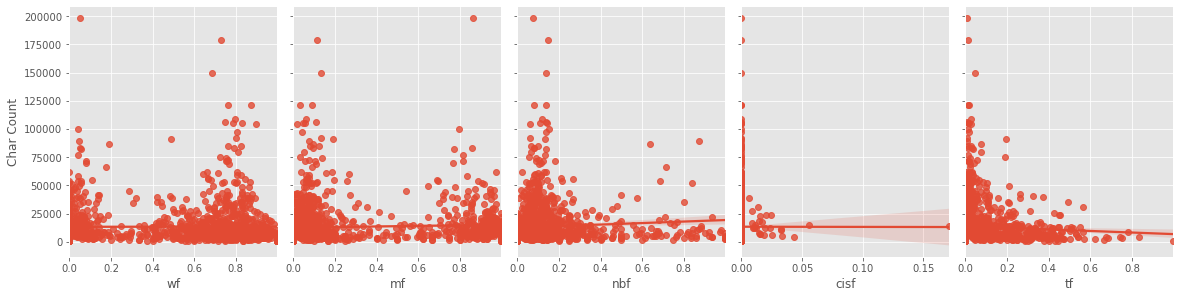

In [68]:
sns.pairplot(allGPAttribs, x_vars=["wf","mf","nbf", "cisf", "tf"], y_vars=["Char Count"],
             height=4, aspect=0.8, kind="reg")

In [72]:
allGPAttribs.corr()

,wf,mf,nbf,cisf,tf,isTrans,Char Count
wf,1.000000,-0.766335,-0.145866,-0.035791,-0.046285,-0.034908,0.005010
mf,-0.766335,1.000000,-0.232152,0.003714,-0.207872,-0.257740,0.057388
nbf,-0.145866,-0.232152,1.000000,-0.005928,-0.023486,0.250049,0.069273
cisf,-0.035791,0.003714,-0.005928,1.000000,0.092852,0.073051,-0.000506
tf,-0.046285,-0.207872,-0.023486,0.092852,1.000000,0.654133,-0.050913
isTrans,-0.034908,-0.257740,0.250049,0.073051,0.654133,1.000000,-0.068096
Char Count,0.005010,0.057388,0.069273,-0.000506,-0.050913,-0.068096,1.000000


In [75]:
allGPAttribs.rename(columns={'Char Count':'CharCount'}, inplace = True)
lm = smf.ols(formula="CharCount   ~  wf + mf + nbf + cisf + tf", data=allGPAttribs).fit()
lm.params

Intercept      876.401090
wf           12549.235726
mf           14042.301315
nbf          17972.967251
cisf         20418.011509
tf            4558.257877
dtype: float64

In [76]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              CharCount   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     9.415
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           7.60e-09
Time:                        16:33:46   Log-Likelihood:                -16372.
No. Observations:                1468   AIC:                         3.276e+04
Df Residuals:                    1462   BIC:                         3.279e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    876.4011   2165.396      0.405      0.686   -3371.213    5124.016
wf          1.255e+04   2310.081      5.432      0.000    8017.809    1.71e+04
mf          1.404e+04   2344.303      5.990      0.000    9443.745    1.86e+04
nbf         1.797e+04   3132.386      5.738      0.000    1.18e+04    2.41e+04
cisf        2.042e+04   8.25e+04      0.248      0.804   -1.41e+05    1.82e+05
tf          4558.2579   4027.819      1.132      0.258   -3342.664    1.25e+04
==============================================================================
Omnibus:                     1305.212   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44548.693
Skew:                           4.102   Prob(JB):                         0.00
Kurtosis:                      28.710   Cond. No.                         216.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
variables = ['wf', 'mf', 'nbf', 'cisf', 'tf']
X = allGPAttribs[variables]
y = allGPAttribs.CharCount
print(X.shape)
print(y.shape)

(1468, 5)
(1468,)


In [79]:
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print(lm.intercept_)
print(lm.coef_)

876.4010900482153
[12549.23572628 14042.30131453 17972.96725148 20418.01150863
  4558.25787741]


In [80]:
list(zip(variables, lm.coef_))

[('wf', 12549.235726280493),
 ('mf', 14042.30131453044),
 ('nbf', 17972.967251480066),
 ('cisf', 20418.011508633692),
 ('tf', 4558.257877408071)]

In [81]:
lm.score(X, y)

0.03119357502513742

Let's make a wordcloud of all of the non-binary pages

In [44]:
def updateStopWords(language, optionalset = None):
    '''Takes two parameters, the name of a language and a set of words.
    The latter may be necessary if you wish to provide a longer set of
    stop words than the NLTK set. This allows you to tweak the wordcloud
    by removing frequent words which are insignificant.'''
    # if the user does not imput a stopwords set, we'll set it to the 
    # default set from nltk for that language
    if optionalset == None:
        return set(stopwords.words(language))   
    else: 
        return optionalset.union(set(stopwords.words(language)))

# helper function that Eni wrote (day 3 notebook)
def plotWordCloud(wcloudObj):
    """Simple function to plot the wordcloud"""
    plt.figure() 
    plt.imshow(wcloudObj, interpolation="bilinear") 
    plt.axis("off") 
    plt.margins(x=0, y=0) 
    plt.show() 
    
def createWordCloud(text, stopwords, filename, width, height, maxWords, backColor, colormap):
    """takes the text as a string, the set of stopwords, the filename to save the wordcloud 
    image, the size of the image (width and height), max number of words, background color, 
    and a colormap. Display the wordcloud on the notebook, but also saves it as a PNG file  
    so that it can be embedded into other documents easily (for example on a webpage)."""
    # create counter of all words in text
    #bigBlob = TextBlob(text)
    #wordFreq = Counter(bigBlob.word_counts)
    # filter out words that are stopwords and adjust counter for word frequencies
    #wordFreqFiltered = Counter({w: wordFreq[w] for w in wordFreq if w not in stopwords})
    
    # create wordcloud object
    
    wcloud = WordCloud(stopwords=stopwords,  
                       width=width, 
                       height=height, 
                       max_words=maxWords, 
                       colormap=colormap, 
                       background_color=backColor).generate(text)
    
    # save word cloud to PNG file
    png = wcloud.to_file(filename + ".png")
    # plot wordcloud using helper function
    plotWordCloud(wcloud)
    

In [45]:
wikiSet = {'\n', 'Archived', 'Retrieved', 'January', 'February', 'March', 'April', 'May',
          'June', 'July', 'August', 'September', 'October', 'November', 'December', 'released', 
          'edit', 'personal life', 'make', 'references', 'References', 'edit', 'appeared', 'b', 'c',
          'would', 'list', "I'm", 'two', 'Early life', 'Personal life', 'year', 'title', 'Year', 'Title', 'com', 'say', 'like', 'Day', 
          'U', 'External link', 'Get', 'said', 'use', 'talk', 'external link', 'External  link', 
          'one', 'also'}
wikiStops = updateStopWords('english', wikiSet)
nbWiki, nbNone = addTextAllDct(nbList)
nbText = getAllTextList(nbWiki)

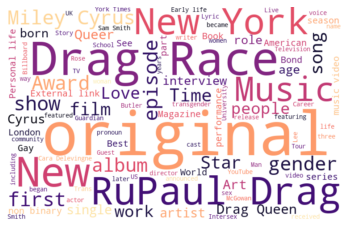

In [46]:
createWordCloud(nbText, wikiStops, 'nb_wcloud', 750, 480, 100, 'white', 'magma')

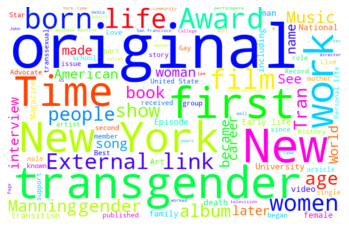

In [48]:
createWordCloud(transText, wikiStops, 'trans_wcloud', 750, 480, 100, 'white', 'gist_rainbow')

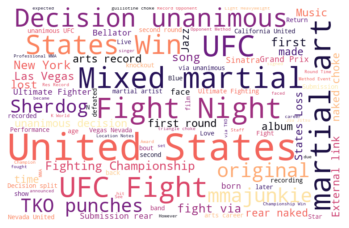

In [49]:
createWordCloud(menText, wikiStops, 'men_wcloud', 750, 480, 100, 'white', 'magma')

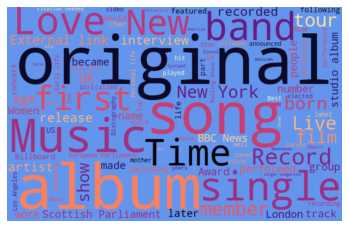

In [55]:
createWordCloud(womenText, wikiStops, 'women_wcloud', 750, 480, 100, 'cornflowerblue', 'magma')